**Nuclei segmentation in whole slide H&E images**

using custom model.

In [101]:
import numpy as np
import matplotlib.pyplot as plt

from tifffile import imread, imsave
from csbdeep.utils import Path, normalize
from csbdeep.utils.tf import keras_import
keras = keras_import()

from stardist import export_imagej_rois, random_label_cmap
from stardist.models import StarDist2D

np.random.seed(0)
cmap = random_label_cmap()

In [102]:
def show_image(img, crop_x, crop_y, tile_size, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the original image on the left
    ax[0].imshow(img, **kwargs)

    # Crop the image
    cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

    # Plot the cropped image on the right
    ax[1].imshow(cropped_img, **kwargs)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

In [103]:
import os
from glob import glob

pth = r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles'  # path of ndpi files
WSIs = sorted(glob(r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\*.ndpi'))

pth_mat = r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\10x\matfiles'
crop_mats = [_ for _ in os.listdir(pth_mat) if _.endswith('mat')]

In [104]:
from scipy.io import loadmat

def get_crop_info(crop_mat_file_path, ratio) -> tuple:
    data = loadmat(crop_mat_file_path)

    offset = 1024/4 + 1024/8
    crop_width = 256
    crop_height = 256
    crop_x = int(data['crop_x']*ratio + offset)
    crop_y = int(data['crop_y']*ratio)

    return (crop_x, crop_y, crop_width)

In [105]:
ind = 0

mat_file_path = os.path.join(pth_mat, crop_mats[ind])
res20x=0.4416
res10x=1
ratio = res10x/res20x

crop_x, crop_y, tile_size = crop_info = get_crop_info(mat_file_path, ratio)

Run next cell if you have lots of memory and want to store multiple ndpis in RAM --> so probably don't run

In [106]:
from csbdeep.utils import normalize
import sys
from tqdm import tqdm

ind = 1

# you might need to run "pip install imagecodecs" if you get jpeg compression error

imgs = list(map(imread, WSIs))
n_channel = 1 if imgs[0].ndim == 2 else imgs[0].shape[-1]  #If no third

# axis_norm = (0,1)   # normalize channels independently
axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

imgs = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(imgs)]

KeyboardInterrupt: 

Run this one instead to load just 1 ndpi in RAM

In [ ]:
from csbdeep.utils import normalize
import sys
from tqdm import tqdm

ind = 1

# you might need to run "pip install imagecodecs" if you get jpeg compression error

img = imread(WSIs[ind])
n_channel = 1 if img[0].ndim == 2 else img[0].shape[-1]  #If no third

# axis_norm = (0,1)   # normalize channels independently
axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

img = normalize(img,1,99.8,axis=axis_norm)

In [ ]:
show_image(img, crop_x, crop_y, tile_size)

In [ ]:
model = StarDist2D(None, name='monkey_tile_trained', basedir=r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\stardist_models')

In [ ]:
def show_image(img, crop_x, crop_y, tile_size, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the original image on the left
    ax[0].imshow(img, **kwargs)

    # Crop the image
    cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

    # Plot the cropped image on the right
    ax[1].imshow(cropped_img, **kwargs)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
#Slow - takes time to segment the large image

# img = imgs[ind]

labels, polys = model.predict_instances_big(img, axes='YXC', block_size=4096, min_overlap=128, context=128, n_tiles=(4,4,1))

In [ ]:
show_image(labels, crop_x, crop_y, tile_size, cmap=cmap)

In [ ]:
show_image(img, crop_x, crop_y, tile_size, cmap=cmap)

In [ ]:
#cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]
#cropped_lbl = labels[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

tile_size = 256

y_cor = 16280
y_cor_end = y_cor + tile_size
x_cor = 14170
x_cor_end = x_cor + tile_size

cropped_img = img[y_cor:y_cor_end, x_cor:x_cor_end]
cropped_lbl = labels[y_cor:y_cor_end, x_cor:x_cor_end]

lbl_cmap = random_label_cmap()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


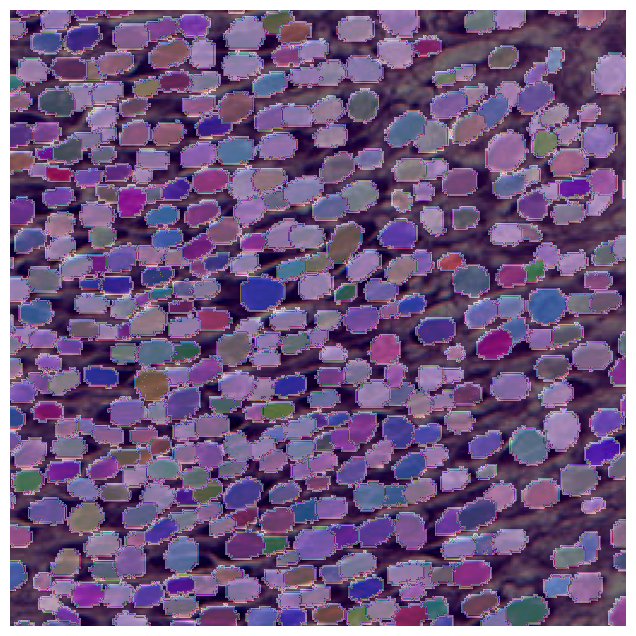

In [111]:
plt.figure(figsize=(8, 8))
plt.imshow(cropped_img, cmap='gray')
plt.imshow(cropped_lbl, cmap=lbl_cmap, alpha=0.5)
plt.axis('off')
plt.show()

In [109]:
model_pre = StarDist2D.from_pretrained('2D_versatile_he')

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [112]:
labels_pre, polys_pre = model_pre.predict_instances_big(img, axes='YXC', block_size=4096, min_overlap=128, context=128, n_tiles=(4,4,1))

effective: block_size=(4096, 4096, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


100%|██████████| 90/90 [02:42<00:00,  1.81s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


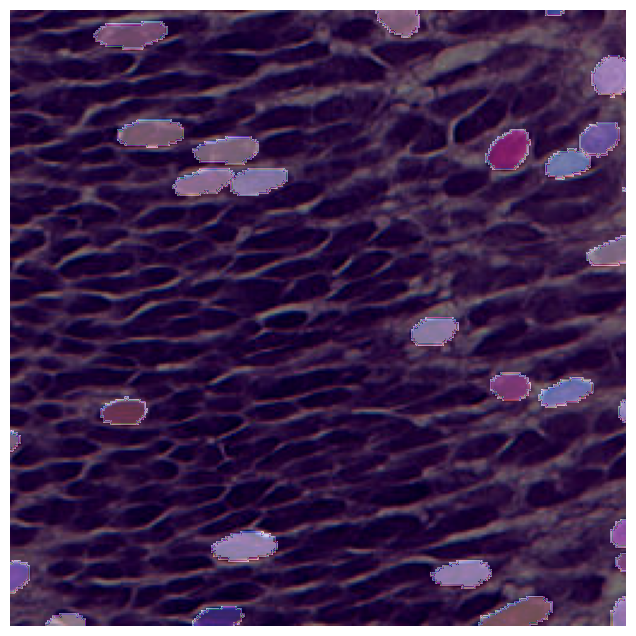

In [113]:
cropped_lbl_pre = labels_pre[y_cor:y_cor_end, x_cor:x_cor_end]

plt.figure(figsize=(8, 8))
plt.imshow(cropped_img, cmap='gray')
plt.imshow(cropped_lbl_pre, cmap=lbl_cmap, alpha=0.5)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


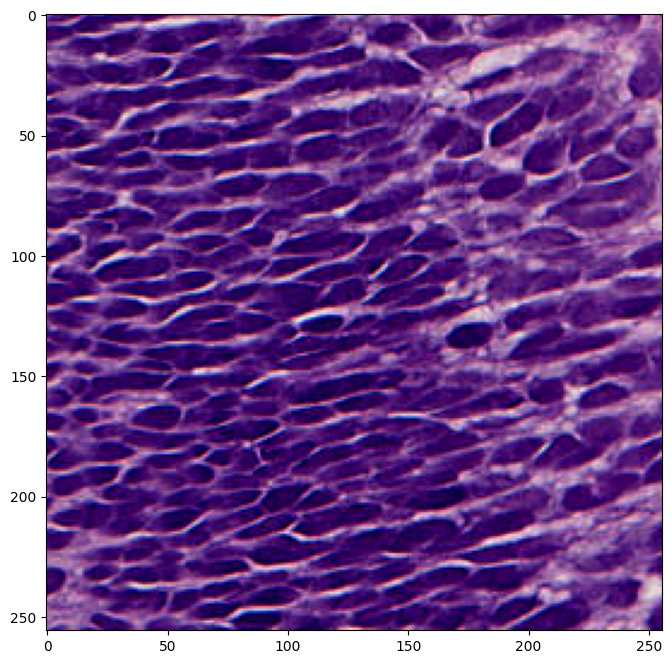

In [107]:
plt.figure(figsize=(8, 8))
plt.imshow(cropped_img)
plt.show()

Some quantifications

In [20]:
from skimage.measure import regionprops_table
import pandas as pd

In [21]:
# Slow - takes time as we have many many objects
props = regionprops_table(labels, img,
                          properties=['label',
                                      'area', 'equivalent_diameter',
                                      'mean_intensity', 'solidity'])


In [22]:
analysis_results = pd.DataFrame(props)
print(analysis_results.tail())

         label  area  equivalent_diameter  mean_intensity-0  mean_intensity-1  \
618435  618436  38.0             6.955796          0.432212          0.354930   
618436  618437  25.0             5.641896          0.262785          0.271899   
618437  618438  23.0             5.411516          0.480737          0.479086   
618438  618439  23.0             5.411516          0.542102          0.447441   
618439  618440  37.0             6.863663          0.470236          0.347588   

        mean_intensity-2  solidity  
618435          0.526649  0.883721  
618436          0.411392  0.833333  
618437          0.597413  0.851852  
618438          0.606494  0.766667  
618439          0.533527  0.973684  


In [23]:
import seaborn as sns

<Axes: xlabel='area', ylabel='Count'>

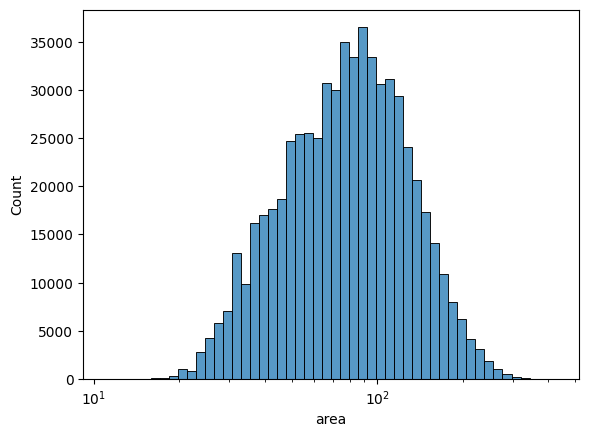

In [24]:
sns.histplot(x="area", data=analysis_results, bins=50, log_scale=True)